# Parameter sensitivity analysis

Model optimised based on data from [Tsutsumi _et al._ 2011](https://doi.org/10.1038/nsmb.2125).


## Setup

In [1]:
#setup workspace
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from scipy.integrate import solve_ivp
import  model_utils as mu
import cma
import os
from tqdm import tqdm

In [2]:
#set up initial conditions
##initial concentrations (nM) as outlined in Tsutsumi et al.
pre_wt = 1
pre_sl = 1
wt_dcr = 0
sl_dcr = 0
wt_dcr_star = 0
sl_dcr_star = 0
dcr_wt = 5 #free Dicer in WT system
dcr_sl = 5 #free Dicer in SL system
wt = 0
sl = 0

init_values = [pre_wt, pre_sl, wt_dcr, sl_dcr, wt_dcr_star, sl_dcr_star, dcr_wt, dcr_sl, wt, sl]

##measured affinities for wt, sl pre-miRNAs (nM)
Kd_wt = 25.4
Kd_sl = 147.7

##initial theta (reaction rates) to be optimised:
ka_wt = 5
ka_sl = 5
kc_wt = .1
kc_sl = .1
kd = 5 

theta = np.log(np.array([ka_wt, ka_sl, kc_wt, kc_sl, kd, kd])) #log theta to prevent negative reaction rates in optimisation

#experimental data from figure 1, tsutsumi et al. to pass to optimiser
##extracted from graph
WT_data = np.array([0, 0.11144276160503169, 0.16566679779700877, 0.23905143587726366, 0.2954956726986665, 0.2946793863099961])
short_data = np.array([0, 0.0033684107002276975, 0.007599822974028003, 0.010019177812737812, 0.009603658536577298, 0.01242378048779691])
##simulation time and time steps
time = np.array([0, 5, 10, 20, 40, 60])
minutes = 60

### Functions

In [3]:
#model
def optim_model(t, init_values, ka1, ka2, kc1, kc2, kd1, kd2):
    """
    Model for optimising parameters for expanded model. Using short loop and wt maturing 
    miRNAs in separate Dicer pool.
    """   
    kb1 = ka2 * Kd_wt #Kd = kb / ka
    kb2 = ka2 * Kd_sl
    
    init_pMiR1, init_pMiR2, init_pMiR1_dcr, init_pMiR2_dcr, init_pMiR1_dcr_star, \
    init_pMiR2_dcr_star, init_dcr1, init_dcr2, init_miR1, init_miR2 = init_values
    
    pMiR1 = init_pMiR1_dcr * kb1 - init_pMiR1 * init_dcr1 * (ka1 + kc1)
    pMiR1_dcr = init_pMiR1 * init_dcr1 * ka1 - init_pMiR1_dcr * (kb1 + kd)
    pMiR1_dcr_star = init_pMiR1 * init_dcr1 * kc1
    dcr1 = init_pMiR1_dcr * (kb1 + kd) - init_pMiR1 * init_dcr1 * (ka1 + kc1)
    MiR1 = init_pMiR1_dcr * kd1
    
    pMiR2 = init_pMiR2_dcr * kb2 - init_pMiR2 * init_dcr2 * (ka2 + kc2)
    pMiR2_dcr = init_pMiR2 * init_dcr2 * ka2 - init_pMiR2_dcr * (kb2 + kd)
    pMiR2_dcr_star = init_pMiR2 * init_dcr2 * kc2
    dcr2 = init_pMiR2_dcr * (kb2 + kd) - init_pMiR2 * init_dcr2 * (ka2 + kc2)
    MiR2 = init_pMiR2_dcr * kd2

    
    return pMiR1, pMiR2, pMiR1_dcr, pMiR2_dcr, pMiR1_dcr_star, pMiR2_dcr_star, dcr1, dcr2, MiR1, MiR2
    

In [4]:
#calculate fraction diced
def frac_diced(theta):
    """
    Function to calculate the fraction of WT, short loop miRNAs diced
    """
    ka1, ka2, kc1, kc2, kd1, kd2 = np.exp(theta)
        
    sol = solve_ivp(optim_model, (0, int(minutes)), init_values, \
                    method = 'LSODA', args = (ka1, ka2, kc1, kc2, kd1, kd2))
    
    pMiR1, pMiR2, pMiR1_dcr, pMiR2_dcr, pMiR1_dcr_star, pMiR2_dcr_star, dcr1, dcr2, MiR1, MiR2 = sol.y
    
    diced1 = []
    diced2 = []
    
    for i in range(len(MiR1)):
        diced1.append(MiR1[i]/ pMiR1[0]) #1 pMiR = 1 MiR
        diced2.append(MiR2[i] / pMiR2[0]) #using pMiR and MiR to account for loss of pMiR
                                                      #in pMiR_dcr_star
                      
    return diced1, diced2, sol.t

In [5]:
#create error function
def errorODE(theta):
    """
    Function to calculate the relative error of ODE model values against data values.
    """
    
    diced1, diced2, ts = frac_diced(theta)
    
    data = np.array([[WT_data],
                     [short_data*10]])#scale by 10 to force optimisation to account for relative changes
    WT = np.interp(time, ts, diced1)
    short = np.interp(time, ts, diced2)

    
    model = np.array([[WT],
                      [short*10]])#scale by 10 to force optimisation to account for relative changes
    
    return np.sum(np.power((data-model), 2))
    

In [94]:
for i in range(65, 100, 1):
    print(i)

65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## Optimisation

In [95]:
#minimise with CMA-ES
##NB! Optimised values vary between optimisation runs!
##Run optimisation 100 times
results = []
ix = ['fmin', 'log ka_wt', 'log ka_short', 'log kc_wt', 'log kc_short', 'log kd_wt', 'log kd_short']
for i in tqdm(range(65, 100, 1)):
    res = cma.fmin(errorODE, theta, 2)
    results.append([res[1], res[0][:]])
    os.renames('outcmaes', 'outcmaes' + str(i))


  0%|          | 0/35 [00:00<?, ?it/s]

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=518386, Fri Dec  1 12:22:50 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 6.157087130949118e-02 1.0e+00 2.01e+00  2e+00  2e+00 0:00.0
    2     18 4.133012457512896e-01 1.3e+00 2.00e+00  2e+00  2e+00 0:00.1
    3     27 8.679977376245078e-02 1.4e+00 2.16e+00  2e+00  2e+00 0:00.1
   95    855 2.684990390682896e-02 1.3e+02 3.90e-02  6e-04  6e-02 0:03.1
  100    900 2.684872232093352e-02 1.4e+02 3.12e-02  5e-04  4e-02 0:03.3
  200   1800 2.684638874176602e-02 3.8e+03 2.10e-02  1e-04  5e-02 0:06.6
  300   2700 2.684627604593754e-02 1.3e+05 8.15e-03  1e-05  2e-02 0:09.6
  400   3600 2.684627523863054e-02 3.0e+05 1.16e-02  6e-06  3e-02 0:12.6
  500   4500 2.684627536880577e-02 5.2e+05 6.46e-03  1e-06  1e-02 0:15.8
  600   5400 2.684627530053179e-02 7.1e+05 1.10e-02  2e-06  4e-03 0:19.5


C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=614)
  warnings.warn(msg + ' (' +


  635   5715 2.684627521815891e-02 3.2e+00 1.47e-02  1e-02  2e-02 0:20.7


  3%|▎         | 1/35 [00:22<12:51, 22.70s/it]

termination on tolstagnation=256 (Fri Dec  1 12:23:13 2023)
final/bestever f-value = 2.684628e-02 2.684628e-02
incumbent solution: [10.482847465006293, -3.1359388567853994, 1.1543404478017862, -11.015596330382841, 0.10116767550561345, -2.864004348992693]
std deviation: [0.01513667617347665, 0.019303106546477666, 0.012434823571946843, 0.01914107032373059, 0.011236753062823608, 0.015119013079293458]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=449525, Fri Dec  1 12:23:13 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 9.109368197188695e-01 1.0e+00 1.84e+00  2e+00  2e+00 0:00.0
    2     18 5.697099613831872e-01 1.3e+00 1.78e+00  2e+00  2e+00 0:00.1
    3     27 1.489424196861575e-01 1.3e+00 1.80e+00  2e+00  2e+00 0:00.1
   86    774 2.685158848264597e-02 9.0e+01 3.73e-01  7e-03  6e-01 0:03.1
  100    900 2.685104124372004e-02 2.5e+02 1.65e-01  2e-03  3e-01 0:03.6
  200   1800 2.684714941656801e-02 1.0e+03 3.96e-03  2e-05  7e-03 0:07.0

C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=987)
  warnings.warn(msg + ' (' +


 1000   9000 2.684709714954808e-02 2.3e+00 3.84e-04  3e-04  4e-04 0:37.4
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1050   9450 2.684709718290674e-02 8.6e+00 2.75e-03  2e-03  5e-03 0:39.2


  6%|▌         | 2/35 [01:05<18:56, 34.44s/it]

termination on tolstagnation=256 (Fri Dec  1 12:23:55 2023)
final/bestever f-value = 2.684710e-02 2.684707e-02
incumbent solution: [8.414300516387357, -3.1721263507732544, -7.017829171062374, -8.32947945030719, 0.10106987844609705, -2.851030245431616]
std deviation: [0.005321331327437211, 0.0031198267305322315, 0.002243256494518647, 0.002318895591443188, 0.0024486090525178083, 0.00230537333319336]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=573440, Fri Dec  1 12:23:55 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 6.110668995174831e+00 1.0e+00 2.00e+00  2e+00  2e+00 0:00.0
    2     18 3.785597224333728e-02 1.3e+00 1.94e+00  2e+00  2e+00 0:00.1
    3     27 3.279208047928394e-02 1.4e+00 2.02e+00  2e+00  2e+00 0:00.1
   96    864 4.764568382936014e-03 6.1e+01 2.21e-02  1e-03  4e-02 0:03.1
  100    900 4.764651329025855e-03 7.4e+01 1.85e-02  9e-04  3e-02 0:03.3
  200   1800 4.758555050742005e-03 1.4e+02 5.92e-04  2e-05  3e-04 0:06.3

  9%|▊         | 3/35 [01:29<15:47, 29.61s/it]

termination on tolstagnation=256 (Fri Dec  1 12:24:19 2023)
final/bestever f-value = 4.758554e-03 4.758554e-03
incumbent solution: [-1.462260405916749, 0.8962571963876412, -14.625361422159031, 1.05706005147567, 0.4033950548175327, 1.3218494308992024]
std deviation: [3.247340096349911e-09, 8.104032153710466e-09, 1.0121988621853873e-07, 9.99548023466729e-09, 5.14999568784458e-10, 2.5328031258860766e-09]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=504155, Fri Dec  1 12:24:19 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.545474953477942e-01 1.0e+00 1.97e+00  2e+00  2e+00 0:00.0
    2     18 1.017808305163419e-01 1.2e+00 2.03e+00  2e+00  2e+00 0:00.1
    3     27 7.968793350324299e-02 1.4e+00 2.25e+00  2e+00  2e+00 0:00.1
   88    792 6.797511672820750e-02 2.4e+02 1.73e-01  1e-02  3e-01 0:03.1
  100    900 6.797510573798467e-02 6.9e+02 9.10e-02  8e-03  1e-01 0:03.6
  200   1800 6.797510532812544e-02 8.2e+03 1.44e-02  1e-03  1e-02 0:

 11%|█▏        | 4/35 [01:39<11:17, 21.87s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:24:29 2023)
final/bestever f-value = 6.797511e-02 6.792045e-02
incumbent solution: [6.368194124410815, -2.4552548990211522, 5.357811884698, 7.832001209179957, 0.5216344426254464, -12.605506665606088]
std deviation: [0.0007619480260338952, 0.00015058496554744513, 0.000720157133720523, 0.0007471480150320461, 5.6588101179150644e-05, 0.0005145771235519725]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=551631, Fri Dec  1 12:24:29 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.578242114978769e-01 1.0e+00 1.96e+00  2e+00  2e+00 0:00.0
    2     18 5.948505517746256e-02 1.3e+00 2.10e+00  2e+00  2e+00 0:00.1
    3     27 6.351975321190519e-02 1.3e+00 2.14e+00  2e+00  2e+00 0:00.1
   85    765 2.826607120546270e-02 5.4e+01 1.19e+00  4e-02  2e+00 0:03.2
  100    900 2.700626355995400e-02 6.2e+01 7.66e-01  2e-02  1e+00 0:03.8
  200   1800 2.684915712861997e-02 6.2e+02 2.54e-02  7e-05  4e-02 0:08.0
  

 14%|█▍        | 5/35 [02:05<11:46, 23.54s/it]

termination on tolstagnation=256 (Fri Dec  1 12:24:56 2023)
final/bestever f-value = 2.684914e-02 2.684820e-02
incumbent solution: [26.853629751763577, -3.9123168621661333, -1.4772004436646047, -4.9890331268020045, 0.10103479729716858, -2.4291924111839007]
std deviation: [2.757967695598206e-05, 7.206410551491988e-06, 0.00013009314477180456, 4.207336930849149e-06, 1.886600404485906e-07, 2.837164677821744e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=507778, Fri Dec  1 12:24:56 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 5.384793741806317e-01 1.0e+00 1.89e+00  2e+00  2e+00 0:00.0
    2     18 2.752863398923593e-01 1.3e+00 2.07e+00  2e+00  2e+00 0:00.1
    3     27 1.655103877866655e-01 1.6e+00 1.99e+00  2e+00  2e+00 0:00.1
  100    900 4.176220184059576e-02 1.3e+02 1.89e-02  1e-03  2e-02 0:02.8
  200   1800 4.176162356623825e-02 1.1e+02 1.77e-03  3e-05  1e-03 0:05.2
  300   2700 4.176162193305659e-02 1.2e+02 3.16e-04  2e-06  6

 17%|█▋        | 6/35 [02:32<11:58, 24.77s/it]

termination on tolstagnation=256 (Fri Dec  1 12:25:23 2023)
final/bestever f-value = 4.176440e-02 4.176162e-02
incumbent solution: [3.9180479915058313, 6.409806063930135, -7.028113406859595, 10.080424560501466, 0.45771877232332014, -1.83669263528869]
std deviation: [1.3356768845941001e-05, 1.3212297218803337e-05, 4.071515161012217e-08, 6.503619286547943e-06, 2.0611460817377976e-07, 7.757760678819044e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=481504, Fri Dec  1 12:25:23 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.363946563783401e-01 1.0e+00 1.88e+00  2e+00  2e+00 0:00.0
    2     18 1.528798723869274e-01 1.3e+00 1.79e+00  2e+00  2e+00 0:00.1
    3     27 8.149572416760682e-02 1.3e+00 1.94e+00  2e+00  2e+00 0:00.1
   82    738 2.686292636605157e-02 7.1e+01 1.98e-01  7e-03  3e-01 0:03.1
  100    900 2.684857480897449e-02 1.1e+02 4.04e-02  1e-03  4e-02 0:03.7
  200   1800 2.684825071297417e-02 4.4e+02 7.08e-03  7e-05  1e-02

 20%|██        | 7/35 [02:59<11:50, 25.38s/it]

termination on tolstagnation=256 (Fri Dec  1 12:25:49 2023)
final/bestever f-value = 2.684820e-02 2.684704e-02
incumbent solution: [5.498428753770873, -3.123379851543718, 1.9502469339569004, -17.056708418054505, 0.13565120790777793, -2.8657331938883592]
std deviation: [6.97061733422566e-06, 8.170777775824709e-06, 0.00015981420640008188, 0.02685108958690222, 5.256661611618018e-06, 1.542011441572329e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=626999, Fri Dec  1 12:25:49 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 8.891907930482504e-01 1.0e+00 2.04e+00  2e+00  2e+00 0:00.0
    2     18 9.567285028454753e-02 1.3e+00 1.98e+00  2e+00  2e+00 0:00.1
    3     27 1.294069655722135e-01 1.4e+00 1.99e+00  2e+00  2e+00 0:00.1
   91    819 2.394497398699219e-03 5.1e+01 6.87e-01  7e-02  5e-01 0:03.1
  100    900 2.278828806095752e-03 3.8e+01 5.10e-01  4e-02  4e-01 0:03.4
  200   1800 6.708988620403885e-04 1.4e+02 8.18e-02  1e-03  4e-02 0

 23%|██▎       | 8/35 [03:10<09:17, 20.64s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:26:00 2023)
final/bestever f-value = 6.707407e-04 6.704010e-04
incumbent solution: [-3.911013509132038, -3.134293433217293, -6.962614045680492, -11.534986292729076, 0.4584599286318951, -2.8640380057977004]
std deviation: [1.7224814283519824e-06, 9.669447206718242e-07, 2.387054025071555e-06, 0.0001206835537745907, 4.394298785713378e-07, 5.095191578717993e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=548783, Fri Dec  1 12:26:00 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.788729266301687e-01 1.0e+00 2.17e+00  2e+00  2e+00 0:00.0
    2     18 1.332352703833624e-01 1.4e+00 2.38e+00  2e+00  3e+00 0:00.1
    3     27 1.705284316786114e-01 1.6e+00 2.34e+00  2e+00  3e+00 0:00.1
  100    900 2.833150053593826e-02 5.0e+01 8.32e-01  5e-02  7e-01 0:03.1
  200   1800 2.684814169027216e-02 9.6e+01 2.71e-02  6e-04  1e-02 0:06.7
  300   2700 2.684868296325208e-02 1.0e+02 8.31e-03  8e-05  1e-03 0:1

 26%|██▌       | 9/35 [03:32<09:11, 21.23s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:26:22 2023)
final/bestever f-value = 2.684848e-02 2.684763e-02
incumbent solution: [2.416691866686787, -4.022211193416109, -0.7042841843803819, -4.885282477546532, 0.14805760510900834, -2.362485132580323]
std deviation: [5.376760068313032e-07, 1.5471737735965387e-06, 1.9373914620352788e-05, 1.1417775229321876e-05, 1.296209895283913e-06, 3.7582698329018876e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=583025, Fri Dec  1 12:26:22 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.848652641792486e-01 1.0e+00 1.96e+00  2e+00  2e+00 0:00.0
    2     18 1.527388046165169e-01 1.3e+00 2.07e+00  2e+00  2e+00 0:00.1
    3     27 1.105470601336962e-01 1.5e+00 2.03e+00  2e+00  2e+00 0:00.1
   90    810 4.731430836334002e-03 1.7e+02 1.04e-01  1e-02  2e-01 0:03.2
  100    900 3.771785244343437e-03 2.2e+02 7.63e-01  9e-02  2e+00 0:03.5


C:\Users\op20001\AppData\Roaming\Python\Python39\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


  192   1728 1.239194584791296e-03 7.1e+02 2.61e-01  5e-03  3e-01 0:08.5
  200   1800 1.244039775846909e-03 7.4e+02 1.75e-01  3e-03  2e-01 0:09.2
  289   2601 1.240073276296633e-03 1.7e+03 3.57e-02  4e-04  2e-02 0:16.2
  300   2700 1.235050485725464e-03 1.8e+03 4.20e-02  4e-04  3e-02 0:17.1
  400   3600 1.238699925787068e-03 8.3e+03 9.36e-02  4e-04  4e-02 0:25.4
  500   4500 1.238999415154882e-03 4.4e+04 8.61e-02  2e-04  3e-02 0:34.3
  505   4545 1.242907738774885e-03 4.3e+04 6.83e-02  2e-04  2e-02 0:34.8


 29%|██▊       | 10/35 [04:08<10:47, 25.90s/it]

termination on tolstagnation=256 (Fri Dec  1 12:26:59 2023)
final/bestever f-value = 1.248583e-03 1.200412e-03
incumbent solution: [11.777056759325102, 29.649937526493872, -4.03155030663654, -8.218303079164489, 15.881850078271139, -2.9820870175942726]
std deviation: [0.018249765757840115, 0.00824250487971158, 0.0007075304676630296, 0.003637428672226495, 0.020880908211144626, 0.00019326612241957173]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=509414, Fri Dec  1 12:26:59 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.323181804789277e+00 1.0e+00 1.97e+00  2e+00  2e+00 0:00.0
    2     18 2.696539580013546e-01 1.4e+00 2.01e+00  2e+00  2e+00 0:00.1
    3     27 2.431383374212087e-01 1.5e+00 2.08e+00  2e+00  2e+00 0:00.1
  100    900 3.096952665125570e-02 4.6e+02 1.56e-02  8e-03  2e-02 0:03.1
  200   1800 3.096948258133499e-02 9.0e+02 3.09e-03  9e-04  4e-03 0:06.4
  300   2700 3.096951323634295e-02 6.3e+03 1.09e-03  3e-04  1e-03 0:09.

 31%|███▏      | 11/35 [04:27<09:24, 23.54s/it]

termination on tolstagnation=256 (Fri Dec  1 12:27:17 2023)
final/bestever f-value = 3.096948e-02 3.095295e-02
incumbent solution: [-1.3599446963129251, -2.7187623883157044, -0.5301043832259403, 3.908671774706206, 1.5025289005467501, 4.5629136704662]
std deviation: [0.0021677438205280797, 0.0013056317859357473, 0.001258551734972385, 0.001056820886452108, 0.00045731139537788344, 0.0006209873312391802]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=572293, Fri Dec  1 12:27:17 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.361872174565901e-01 1.0e+00 2.16e+00  2e+00  2e+00 0:00.0
    2     18 2.736543030048910e-01 1.5e+00 2.49e+00  2e+00  3e+00 0:00.1
    3     27 1.857106234975675e-01 1.7e+00 2.26e+00  2e+00  3e+00 0:00.1
  100    900 1.291392768641315e-03 7.2e+01 2.44e-01  1e-02  5e-01 0:03.1
  200   1800 1.264651028939839e-03 3.1e+03 6.27e-02  3e-04  3e-01 0:05.6
  300   2700 1.264484833137598e-03 2.2e+04 4.87e-03  1e-05  3e-02 0:0

C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=586)
  warnings.warn(msg + ' (' +


  600   5400 1.264485224961691e-03 2.3e+00 9.10e-05  6e-05  1e-04 0:16.1
  670   6030 1.264484871890273e-03 9.1e+00 1.33e-04  9e-05  1e-04 0:17.9


 34%|███▍      | 12/35 [04:47<08:36, 22.45s/it]

termination on tolstagnation=256 (Fri Dec  1 12:27:37 2023)
final/bestever f-value = 1.264487e-03 1.264482e-03
incumbent solution: [5.43678864638089, 7.8862655907138315, -8.515024664237288, -16.759084011353362, 0.4149486837802643, -2.9735866486297677]
std deviation: [0.00011606793340999223, 9.013647834516469e-05, 0.0001368255454834486, 0.00012714013452147063, 0.00013139825566659612, 8.728938672718536e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=539329, Fri Dec  1 12:27:37 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.058960531248151e-01 1.0e+00 1.98e+00  2e+00  2e+00 0:00.0
    2     18 1.533177356753568e-01 1.3e+00 2.16e+00  2e+00  2e+00 0:00.1
    3     27 3.528409502065045e-02 1.6e+00 2.01e+00  2e+00  2e+00 0:00.1
  100    900 6.830316308277574e-04 7.8e+01 1.53e-02  4e-04  3e-02 0:02.1
  200   1800 6.828405288767690e-04 4.5e+02 9.54e-04  1e-05  2e-03 0:03.8
  300   2700 6.813025261864355e-04 3.8e+02 1.87e-01  1e-03  1e-0

 37%|███▋      | 13/35 [05:08<08:06, 22.11s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:27:58 2023)
final/bestever f-value = 6.419252e-04 6.419252e-04
incumbent solution: [-6.515576168346304, -4.578696878328039, -4.086717320856563, -4.447616079555395, 2.9704267505884663, -1.948689424732025]
std deviation: [3.342170891734353e-06, 8.673396727783379e-07, 1.7961658657602817e-06, 3.6649784415397282e-06, 3.930292292606402e-06, 1.272169299226449e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=573775, Fri Dec  1 12:27:58 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.795040927091367e-01 1.0e+00 2.01e+00  2e+00  2e+00 0:00.0
    2     18 6.906826545690993e-02 1.2e+00 1.93e+00  2e+00  2e+00 0:00.1
    3     27 8.095549610881045e-02 1.3e+00 1.92e+00  2e+00  2e+00 0:00.1
   68    612 3.097314159623430e-02 5.3e+01 2.83e-01  1e-02  6e-01 0:03.1
  100    900 2.151057479018127e-02 1.1e+02 1.38e+00  3e-02  3e+00 0:04.6
  200   1800 1.327586985920996e-03 3.2e+02 1.28e+00  1e-02  2e+00 0:08

 40%|████      | 14/35 [05:29<07:37, 21.79s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:28:19 2023)
final/bestever f-value = 6.434421e-04 6.434421e-04
incumbent solution: [-4.912426346360754, -3.1528249075830455, -4.433077586512936, -188.09988708318684, 1.494766171621474, -2.8627929922800206]
std deviation: [9.126390236961301e-06, 1.8125825715509524e-06, 4.824401924593099e-06, 0.011999107028207934, 8.99424393659833e-06, 4.812870110733538e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=535687, Fri Dec  1 12:28:19 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 5.063030925146542e-02 1.0e+00 1.99e+00  2e+00  2e+00 0:00.0
    2     18 7.116740853770695e-02 1.3e+00 1.90e+00  2e+00  2e+00 0:00.1
    3     27 7.856984272313355e-02 1.4e+00 1.67e+00  2e+00  2e+00 0:00.1
  100    900 2.686450640162490e-02 2.5e+01 1.50e-01  3e-02  8e-02 0:02.6
  200   1800 2.684842970370033e-02 2.0e+02 1.47e-02  1e-03  1e-02 0:04.6
  300   2700 2.684835724387040e-02 2.1e+02 2.15e-03  6e-05  3e-04 0:06.

 43%|████▎     | 15/35 [05:39<06:07, 18.36s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:28:30 2023)
final/bestever f-value = 2.684836e-02 2.684836e-02
incumbent solution: [-0.5490559962095947, -3.9857362489342756, 0.21339109621344746, -4.9091775705650464, 1.308765277458446, -2.3822172911358073]
std deviation: [9.963123865335563e-06, 2.6082314278099596e-06, 8.629873637555014e-06, 2.099172816128129e-06, 1.2849686433610003e-05, 6.869262023348232e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=518542, Fri Dec  1 12:28:30 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.154736463066209e-01 1.0e+00 1.94e+00  2e+00  2e+00 0:00.0
    2     18 2.667264184146347e-01 1.4e+00 2.03e+00  2e+00  2e+00 0:00.1
    3     27 6.250871487960219e-02 1.5e+00 1.94e+00  2e+00  2e+00 0:00.1
  100    900 8.494101856319311e-04 2.5e+01 1.37e-01  2e-02  1e-01 0:02.9
  200   1800 6.589621887697784e-04 5.6e+01 1.08e-01  4e-03  3e-02 0:04.3
  300   2700 6.503843007445877e-04 1.9e+02 4.11e-01  9e-03  7e-02 

 46%|████▌     | 16/35 [05:54<05:26, 17.16s/it]

termination on tolstagnation=256 (Fri Dec  1 12:28:44 2023)
final/bestever f-value = 6.448967e-04 6.448490e-04
incumbent solution: [-4.9727950851833755, -3.2503729324518056, -4.413413477607438, -6.857718936155351, 1.537610268864382, -2.8079743470856298]
std deviation: [0.0006368626797506079, 5.9088442982743214e-05, 0.00016477813499201702, 0.010676590411322339, 0.00045676306651041355, 0.000517219376249101]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=505200, Fri Dec  1 12:28:44 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.692383920657957e+00 1.0e+00 1.98e+00  2e+00  2e+00 0:00.0
    2     18 1.635154403501851e-01 1.3e+00 2.16e+00  2e+00  2e+00 0:00.1
    3     27 8.129191678299909e-02 1.5e+00 2.31e+00  2e+00  2e+00 0:00.1
  100    900 1.248732857105108e-03 2.9e+02 1.19e-01  7e-03  3e-01 0:02.8
  200   1800 1.240630552479030e-03 8.7e+02 4.54e-02  4e-04  7e-02 0:05.2
  300   2700 1.240299878233175e-03 8.9e+03 5.52e-02  1e-04  2e-0

 49%|████▊     | 17/35 [06:13<05:22, 17.91s/it]

termination on tolstagnation=256 (Fri Dec  1 12:29:04 2023)
final/bestever f-value = 1.240721e-03 1.240292e-03
incumbent solution: [2.142598937906371, 6.7002649976392705, -4.155033244744298, -18.736718438432177, 2.5638856356730875, -2.97375608058196]
std deviation: [8.947662408327706e-06, 1.4437730089368544e-06, 2.871803311159516e-06, 0.002902675312088677, 1.1196686350368196e-05, 1.1111942354405709e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=555236, Fri Dec  1 12:29:04 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.241952995636124e-01 1.0e+00 1.99e+00  2e+00  2e+00 0:00.0
    2     18 1.528780453734359e-01 1.4e+00 1.85e+00  2e+00  2e+00 0:00.1
    3     27 1.695645236069596e-01 1.5e+00 1.70e+00  1e+00  2e+00 0:00.1
   80    720 2.750328401928440e-02 1.6e+02 3.17e-01  2e-02  5e-01 0:03.2
  100    900 2.746806741099992e-02 5.1e+02 2.39e-01  6e-03  5e-01 0:04.1
  200   1800 2.745941064070130e-02 2.3e+03 9.65e-02  4e-04  1e-01 

 51%|█████▏    | 18/35 [06:36<05:30, 19.46s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:29:27 2023)
final/bestever f-value = 2.745740e-02 2.745740e-02
incumbent solution: [11.78577453663186, 2.4056431244922707, 13.74246842661848, -23.39527123191512, 6.108765824633298, -2.973058877536044]
std deviation: [6.65630916377473e-05, 7.221143621916995e-06, 6.166531097843166e-05, 0.10535528025100424, 8.544942375346355e-06, 8.402496200859678e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=550499, Fri Dec  1 12:29:27 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.322536101306466e-01 1.0e+00 2.27e+00  2e+00  2e+00 0:00.0
    2     18 5.533176376756110e-02 1.2e+00 2.64e+00  2e+00  3e+00 0:00.1
    3     27 1.040982592985748e-01 1.5e+00 2.93e+00  3e+00  4e+00 0:00.1
   96    864 4.819124117929904e-03 4.8e+01 2.78e-01  1e-02  3e-01 0:03.1
  100    900 4.797435910401483e-03 5.9e+01 1.88e-01  7e-03  2e-01 0:03.2
  200   1800 4.789283686620825e-03 5.1e+02 1.96e-02  1e-04  3e-02 0:06.2
  300

 54%|█████▍    | 19/35 [06:50<04:42, 17.65s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:29:40 2023)
final/bestever f-value = 4.789127e-03 4.789127e-03
incumbent solution: [-3.874610226035545, -3.239257576521535, -18.599808659712426, 14.271951686109796, 0.40183940088643255, 15.134057869829622]
std deviation: [2.3398483217330506e-06, 3.7077671555032677e-07, 0.0002470019145773635, 7.682072882583195e-07, 9.467382565740127e-07, 2.061565644976402e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=594859, Fri Dec  1 12:29:40 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.795942655844828e-01 1.0e+00 1.90e+00  2e+00  2e+00 0:00.0
    2     18 2.734444738666647e-01 1.2e+00 2.14e+00  2e+00  2e+00 0:00.1
    3     27 2.763827011239207e-01 1.4e+00 2.20e+00  2e+00  2e+00 0:00.1
   60    540 6.797513308594633e-02 2.2e+02 8.02e-01  1e-02  2e+00 0:03.1
  100    900 6.797510871765200e-02 8.0e+03 4.92e-01  2e-04  1e+00 0:05.4
NOTE (module=cma, iteration=110):  
condition in coordinate system e

 57%|█████▋    | 20/35 [07:02<03:58, 15.87s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:29:52 2023)
termination on tolfunhist=1e-12 (Fri Dec  1 12:29:52 2023)
final/bestever f-value = 6.797511e-02 6.412451e-02
incumbent solution: [10.834323326700522, -49.60371963799422, 2.354458609955479, 57.66433386846535, 0.10126130184326784, 32.42005726908511]
std deviation: [0.004630720702178416, 0.026862774427031676, 0.01303974931421741, 0.020557366496592348, 3.4256923117674663e-06, 0.012150304541420532]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=552675, Fri Dec  1 12:29:52 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.816267867010446e+00 1.0e+00 2.00e+00  2e+00  2e+00 0:00.0
    2     18 3.481275694377202e-01 1.3e+00 2.08e+00  2e+00  2e+00 0:00.1
    3     27 2.757221967369362e-01 1.5e+00 2.39e+00  2e+00  3e+00 0:00.1
   83    747 2.749968570520974e-02 4.0e+01 1.45e-01  1e-02  1e-01 0:03.2
  100    900 1.215063877738338e-02 1.2e+02 1.87e+00  1e-01  3e+00 0:03.7
  200   1800 1.26638

 60%|██████    | 21/35 [07:24<04:10, 17.86s/it]

termination on tolstagnation=256 (Fri Dec  1 12:30:15 2023)
final/bestever f-value = 1.264327e-03 1.262858e-03
incumbent solution: [10.780985503010903, 13.25340309588532, -7.401748476889015, -10.522712859590857, 0.43957483103564077, -2.9704085126303506]
std deviation: [8.859694477746753e-05, 8.906450427877153e-05, 7.878681369755732e-05, 0.00023690542468991202, 3.3425958742438418e-06, 1.6860513238566635e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=457353, Fri Dec  1 12:30:15 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.720230136499669e+00 1.0e+00 2.21e+00  2e+00  3e+00 0:00.0
    2     18 2.033124441003831e-01 1.5e+00 2.42e+00  2e+00  3e+00 0:00.1
    3     27 2.882898913762937e-01 1.8e+00 2.58e+00  2e+00  3e+00 0:00.1
   74    666 3.097005401010819e-02 6.3e+01 6.79e-02  2e-03  9e-02 0:03.2
  100    900 3.096955917745066e-02 2.8e+02 1.40e-02  1e-04  2e-02 0:04.4
  200   1800 3.096955001739933e-02 1.1e+03 1.06e-03  2e-06  5e

 63%|██████▎   | 22/35 [07:55<04:44, 21.86s/it]

termination on tolstagnation=256 (Fri Dec  1 12:30:46 2023)
final/bestever f-value = 3.096955e-02 3.096952e-02
incumbent solution: [9.597449543416408, 2.215128250458867, -1.5024737398207846, 11.500081535572647, 0.1017814267263061, 11.743259680239326]
std deviation: [2.008461856913527e-06, 1.7501519186737966e-06, 1.0724336746140591e-06, 4.845303318716796e-06, 2.409452303174392e-09, 4.836804611125104e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=536878, Fri Dec  1 12:30:46 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.836482901706664e-02 1.0e+00 2.00e+00  2e+00  2e+00 0:00.0
    2     18 9.067042705317918e-02 1.3e+00 2.07e+00  2e+00  2e+00 0:00.1
    3     27 3.377690895298968e-02 1.4e+00 1.92e+00  2e+00  2e+00 0:00.1
   95    855 4.176962426465284e-02 1.3e+02 2.00e-01  3e-02  3e-01 0:03.1
  100    900 4.176723485132623e-02 1.6e+02 2.20e-01  3e-02  3e-01 0:03.3
  200   1800 4.176201379707058e-02 1.3e+03 7.16e-02  1e-03  8e-02 

 66%|██████▌   | 23/35 [08:28<05:01, 25.11s/it]

termination on tolfunhist=1e-12 (Fri Dec  1 12:31:18 2023)
final/bestever f-value = 4.754608e-03 4.754135e-03
incumbent solution: [-6.306190958204943, -2.8539294853277153, -4.092003622191162, 15.59992446702042, 2.9628875071913985, 16.301638974931485]
std deviation: [1.5361733194183404e-05, 1.5713928289263063e-06, 3.339642948033291e-06, 4.8481410915155586e-05, 1.6945273715020685e-05, 4.879573561832392e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=531856, Fri Dec  1 12:31:18 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.390485041467262e-02 1.0e+00 2.06e+00  2e+00  2e+00 0:00.0
    2     18 1.161980007701556e-01 1.3e+00 2.30e+00  2e+00  3e+00 0:00.1
    3     27 6.154534626977856e-02 1.5e+00 2.13e+00  2e+00  2e+00 0:00.1
   76    684 3.096956942851017e-02 1.5e+02 3.02e-02  5e-04  4e-02 0:03.2
  100    900 3.096955110795210e-02 4.2e+02 9.75e-03  1e-04  1e-02 0:04.2
  200   1800 3.096954947893340e-02 1.2e+03 1.16e-02  4e-05  8e-0

 69%|██████▊   | 24/35 [08:42<03:59, 21.81s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:31:33 2023)
final/bestever f-value = 3.096955e-02 3.096954e-02
incumbent solution: [8.774295986035847, 1.7134314782402387, 0.36789165388317707, 4.152410291360087, 0.10755398586338265, 4.398557940477741]
std deviation: [7.649723711970366e-05, 0.0001158458164082882, 0.00027431894140958376, 7.630770804377564e-05, 1.6052527117918606e-06, 7.704673506015854e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=531162, Fri Dec  1 12:31:33 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.514524163310343e-01 1.0e+00 1.81e+00  2e+00  2e+00 0:00.0
    2     18 4.267592926645749e-02 1.2e+00 1.89e+00  2e+00  2e+00 0:00.1
    3     27 3.487107328925910e-02 1.4e+00 1.94e+00  2e+00  2e+00 0:00.1
  100    900 6.766863542215495e-04 1.4e+02 1.21e-01  4e-03  3e-01 0:02.5
  200   1800 6.740300949655604e-04 4.7e+02 8.96e-04  7e-06  1e-03 0:04.1
  300   2700 6.740264968635701e-04 4.1e+04 1.93e-02  3e-05  1e-01 0:05.

 71%|███████▏  | 25/35 [09:14<04:09, 24.90s/it]

termination on tolstagnation=256 (Fri Dec  1 12:32:05 2023)
final/bestever f-value = 6.738776e-04 6.724798e-04
incumbent solution: [-3.9136041551782945, -3.2633952996905897, -7.409027462093658, -7.1467476068301865, 0.43773574515142205, -2.8175853103437145]
std deviation: [0.00024949825920198064, 1.0188146515912178e-05, 0.004488958433178694, 0.00234180268344939, 0.000194974019817527, 0.00012670750125838118]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=509550, Fri Dec  1 12:32:05 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.382875023418128e-02 1.0e+00 1.90e+00  2e+00  2e+00 0:00.0
    2     18 1.649522747980681e-01 1.3e+00 2.09e+00  2e+00  2e+00 0:00.1
    3     27 5.667413652945510e-02 1.5e+00 2.09e+00  2e+00  2e+00 0:00.1
  100    900 4.177618989822295e-02 1.4e+02 7.43e-02  9e-03  1e-01 0:02.7
  200   1800 4.177330061574372e-02 1.8e+02 1.41e-02  1e-03  7e-03 0:05.4
  300   2700 4.177300796262363e-02 1.6e+02 2.15e-02  7e-04  5e-

C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1300)
  warnings.warn(msg + ' (' +


 1310  11790 4.758506745183019e-03 2.2e+00 6.46e-03  7e-03  8e-03 0:35.1


 74%|███████▍  | 26/35 [09:53<04:22, 29.12s/it]

termination on tolstagnation=256 (Fri Dec  1 12:32:44 2023)
final/bestever f-value = 4.758507e-03 4.758507e-03
incumbent solution: [-5.003498263733945, -2.7106133269556665, -4.348304745434518, 3.1081242107689775, 1.6824991269251086, 3.7601301762344974]
std deviation: [0.006507005937182726, 0.0070722428992083105, 0.006711577512040713, 0.007756155317752362, 0.00682375844741437, 0.006643009286225119]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=491985, Fri Dec  1 12:32:44 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.963166361459682e-01 1.0e+00 2.47e+00  2e+00  3e+00 0:00.0
    2     18 1.013787332998990e-01 1.3e+00 3.19e+00  3e+00  3e+00 0:00.1
    3     27 1.848421294250668e-01 1.4e+00 3.15e+00  3e+00  3e+00 0:00.1
   89    801 4.207957254799592e-02 1.7e+02 1.94e+00  1e-01  7e+00 0:03.1
  100    900 4.180746791911344e-02 2.4e+02 1.49e+00  9e-02  5e+00 0:03.5
  200   1800 4.178399627155285e-02 1.4e+03 1.05e-01  4e-03  2e-01 0:06.6

 77%|███████▋  | 27/35 [10:10<03:22, 25.32s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:33:00 2023)
final/bestever f-value = 4.178287e-02 4.178253e-02
incumbent solution: [-4.539090068488473, -4.247702140210356, -4.8519315359820965, 14.744567055798724, 0.9837593788842438, -21.905062568129544]
std deviation: [6.925544972822687e-06, 0.00010518770699542226, 7.899986241635817e-06, 6.992369653721979e-06, 4.285740813774563e-06, 0.0002869762725612797]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=559191, Fri Dec  1 12:33:00 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.670286815657650e-01 1.0e+00 2.25e+00  2e+00  2e+00 0:00.0
    2     18 2.150185514058920e-01 1.3e+00 2.27e+00  2e+00  2e+00 0:00.1
    3     27 2.035068111192570e-01 1.4e+00 2.50e+00  2e+00  3e+00 0:00.1
   93    837 2.684898841300164e-02 8.2e+01 4.68e-02  2e-03  6e-02 0:03.2
  100    900 2.684883031514792e-02 8.5e+01 4.20e-02  2e-03  5e-02 0:03.4
  200   1800 2.684867413312552e-02 1.6e+02 9.11e-03  1e-04  7e-03 0:0

 80%|████████  | 28/35 [10:29<02:44, 23.44s/it]

termination on tolstagnation=256 (Fri Dec  1 12:33:19 2023)
final/bestever f-value = 2.684821e-02 2.684656e-02
incumbent solution: [4.036003295101696, -3.1296049460659905, 0.5672363595605749, -10.85634941203642, 0.1384258155127318, -2.864492397986961]
std deviation: [3.3220446504089145e-08, 3.299340743743239e-08, 8.405582548997125e-07, 2.874667419438772e-06, 2.1054201315370866e-08, 1.4264608187044213e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=551010, Fri Dec  1 12:33:19 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.548058444967254e-01 1.0e+00 1.90e+00  2e+00  2e+00 0:00.1
    2     18 2.360030702804574e-01 1.2e+00 2.12e+00  2e+00  2e+00 0:00.1
    3     27 2.792277672770142e-01 1.5e+00 2.19e+00  2e+00  3e+00 0:00.2
   96    864 3.096961317619636e-02 1.9e+02 1.09e-01  5e-02  2e-01 0:03.2
  100    900 3.096975526693893e-02 2.4e+02 9.66e-02  4e-02  2e-01 0:03.3
  200   1800 3.096955858452740e-02 1.1e+04 2.21e-03  5e-04  4e-0

 83%|████████▎ | 29/35 [10:39<01:57, 19.52s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:33:29 2023)
final/bestever f-value = 3.096956e-02 1.371121e-02
incumbent solution: [2.5576296361350863, -0.6082124855914772, 2.7674889193785237, 1.0271114425578964, 1.8317106003635837, 1.33833026534386]
std deviation: [5.3675719077472036e-05, 2.92359450972902e-05, 3.5032844116121435e-05, 9.843554276742706e-05, 5.560935282601044e-05, 9.628659386125189e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=549135, Fri Dec  1 12:33:29 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.500148440571804e-01 1.0e+00 1.87e+00  2e+00  2e+00 0:00.0
    2     18 5.427592688478206e-02 1.2e+00 1.90e+00  2e+00  2e+00 0:00.1
    3     27 1.809260539384828e-01 1.4e+00 1.84e+00  2e+00  2e+00 0:00.1
  100    900 1.279603488224587e-03 8.3e+01 2.60e-01  2e-02  3e-01 0:03.0
  200   1800 1.254949346321585e-03 1.1e+03 6.55e-02  7e-04  2e-01 0:06.0
  300   2700 1.254745322256652e-03 1.8e+04 4.17e-03  1e-05  3e-02 0:08.9

 86%|████████▌ | 30/35 [11:01<01:41, 20.24s/it]

termination on tolstagnation=256 (Fri Dec  1 12:33:51 2023)
final/bestever f-value = 1.254744e-03 1.254743e-03
incumbent solution: [-0.3360195262553869, 2.2517492919195745, -5.882860940347255, -20.234649760911367, 0.5802679465308467, -2.973015177386463]
std deviation: [6.713664427900406e-08, 4.844210028009673e-08, 3.3919911667672484e-07, 0.00022531990078964982, 6.235166404177553e-08, 4.0038967988509556e-08]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=615180, Fri Dec  1 12:33:51 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.816132642704668e-02 1.0e+00 1.99e+00  2e+00  2e+00 0:00.0
    2     18 1.970024199492713e-01 1.3e+00 2.16e+00  2e+00  2e+00 0:00.1
    3     27 2.801706050895000e-01 1.3e+00 2.16e+00  2e+00  2e+00 0:00.1
   75    675 3.096957052110003e-02 1.1e+02 6.89e-02  2e-03  1e-01 0:03.1
  100    900 3.096954779087112e-02 4.7e+02 3.96e-02  2e-04  8e-02 0:04.3
  200   1800 3.096954643420471e-02 3.9e+03 1.37e-02  2e-05  2e

 89%|████████▊ | 31/35 [11:20<01:19, 19.90s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:34:11 2023)
final/bestever f-value = 3.096954e-02 3.096951e-02
incumbent solution: [5.972308275324789, -8.701698736416747, -3.132468989123917, 3.711698800864986, 0.10116498167148576, 9.272044141534657]
std deviation: [3.12398655581571e-05, 0.0001255905339466433, 0.00021849203458304472, 3.106867390391851e-05, 1.8275353693959968e-07, 9.759977356090805e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=530885, Fri Dec  1 12:34:11 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.679937758830711e-01 1.0e+00 1.95e+00  2e+00  2e+00 0:00.0
    2     18 2.902985350645499e-01 1.2e+00 2.41e+00  2e+00  3e+00 0:00.1
    3     27 1.839259875663445e-01 1.4e+00 2.42e+00  2e+00  3e+00 0:00.1
   88    792 2.684936100258833e-02 5.5e+01 5.86e-02  4e-03  6e-02 0:03.1
  100    900 2.684859254691461e-02 8.8e+01 2.87e-02  2e-03  3e-02 0:03.5
  200   1800 2.684821486120427e-02 6.1e+01 7.77e-03  2e-04  3e-03 0:06.6


 91%|█████████▏| 32/35 [11:32<00:52, 17.58s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:34:23 2023)
final/bestever f-value = 2.684819e-02 2.684708e-02
incumbent solution: [1.6322480176809173, -3.733444836570765, -0.5769074042785464, -5.2374497199881755, 0.21717022104027045, -2.5415202866078763]
std deviation: [8.590513430537749e-07, 1.756729370460797e-06, 1.861300529513869e-05, 1.725713698993237e-05, 1.7340737858914276e-06, 4.475086198118991e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=461158, Fri Dec  1 12:34:23 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.853874173126504e-01 1.0e+00 2.17e+00  2e+00  2e+00 0:00.0
    2     18 2.350680251940695e-01 1.4e+00 2.09e+00  2e+00  2e+00 0:00.1
    3     27 1.522420313314897e-01 1.6e+00 2.23e+00  2e+00  2e+00 0:00.1
   71    639 2.752383074053635e-02 5.0e+01 3.44e-01  1e-02  6e-01 0:03.1
  100    900 2.686059334549553e-02 1.1e+02 3.40e-01  7e-03  5e-01 0:04.2
  200   1800 2.684764865479410e-02 4.3e+02 1.78e-02  8e-05  2e-02 0

 94%|█████████▍| 33/35 [12:00<00:40, 20.50s/it]

termination on tolstagnation=256 (Fri Dec  1 12:34:50 2023)
final/bestever f-value = 2.684760e-02 2.684748e-02
incumbent solution: [11.049116367163451, -3.3142292549190797, -8.188643164327734, -6.436113523067871, 0.10053515589378369, -2.7770011905848455]
std deviation: [0.00012333778297811705, 1.4251124076240936e-06, 3.470992529071492e-05, 4.93185887084751e-05, 3.4185489933881163e-07, 2.4225831294687544e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=545337, Fri Dec  1 12:34:50 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.603413734266080e-01 1.0e+00 2.01e+00  2e+00  2e+00 0:00.0
    2     18 5.868955747962096e-02 1.4e+00 2.02e+00  2e+00  2e+00 0:00.1
    3     27 6.009082802452675e-02 1.5e+00 2.02e+00  2e+00  2e+00 0:00.1
   82    738 2.077424731680832e-03 3.0e+01 8.66e-01  7e-02  1e+00 0:03.1
  100    900 1.405029753167316e-03 5.0e+01 2.93e-01  2e-02  4e-01 0:03.6
  200   1800 1.274905052233407e-03 3.3e+02 1.42e-02  2e-04  1

 97%|█████████▋| 34/35 [12:18<00:19, 19.81s/it]

termination on tolstagnation=256 (Fri Dec  1 12:35:08 2023)
final/bestever f-value = 1.277273e-03 1.273342e-03
incumbent solution: [12.44292132174552, 14.884692296267584, -9.404135382288555, -8.604337467107213, 0.406122035615997, -2.968928146163254]
std deviation: [0.002563517766589528, 0.0026747909564480993, 0.0013233074905710375, 0.0019766090683136744, 3.369428686697757e-05, 0.00019289859160395443]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=530053, Fri Dec  1 12:35:08 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.054923816149529e-01 1.0e+00 2.27e+00  2e+00  2e+00 0:00.0
    2     18 2.650667256559151e-01 1.3e+00 2.37e+00  2e+00  2e+00 0:00.1
    3     27 2.624314502796823e-01 1.3e+00 2.30e+00  2e+00  2e+00 0:00.1
  100    900 4.790608522041340e-03 4.8e+01 1.70e-02  9e-04  2e-02 0:02.7
  200   1800 4.789808723291255e-03 1.3e+02 8.03e-04  1e-05  4e-04 0:05.1
  300   2700 4.789806424366759e-03 4.9e+03 2.66e-04  7e-06  1e-04 0:0

100%|██████████| 35/35 [12:56<00:00, 22.17s/it]

termination on tolfun=1e-11 (Fri Dec  1 12:35:46 2023)
final/bestever f-value = 4.752723e-03 4.752723e-03
incumbent solution: [-21.92438183593143, -2.812653083757305, -4.005294493350792, -0.27098929870785254, 18.59684485660734, 0.4436423310951802]
std deviation: [0.0515242263092396, 2.134042016805179e-08, 8.066394989122413e-07, 2.7864717570627165e-08, 0.05152413566856415, 4.1205700466063137e-07]


In [22]:
reses = []
for i in range(len(results)):
    ka1, ka2, kc1, kc2, kd1, kd2 = results[i][1]
    reses.append([results[i][0], ka1, ka2, kc1, kc2, kd1, kd2])

In [27]:
results = np.array(reses)
results.shape

(66, 7)

In [6]:
df = pd.DataFrame(results, columns = ix)
df.to_csv('param_vars.csv', index = False)

NameError: name 'results' is not defined

## Plotting parameter values

In [ ]:
results = []
for i in tqdm(range(100)):
    dat_vals = pd.read_csv('outcmaes' + str(i) + '/xrecentbest.dat', delimiter = '\\s', engine = 'python')
    results.append(list(dat_vals.iloc[-1, 5:11]))

In [7]:
param_vals = np.exp(np.array(results))

In [8]:
xlabels = ['$k_{a_{WT}}$', '$k_{c_{WT}}$', '$k_{d_{WT}}$',
           '$k_{a_{SL}}$', '$k_{c_{SL}}$', '$k_{d_{SL}}$',]

In [9]:
means = []
stdevs = []
for i in range(param_vals.shape[1]):
    means.append(np.mean(param_vals[:,i]))
    stdevs.append(np.std(param_vals[:,i]))

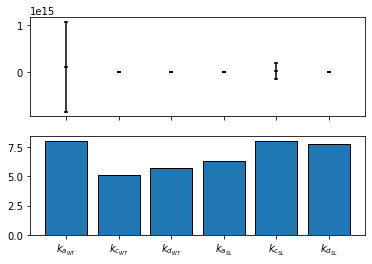

In [10]:
fig, ax = plt.subplots(2, sharex = True)
x = np.linspace(1, 6, len(means))

ax[0].scatter(x,
           means,
           marker = '_',
           s = 20,
           color = 'black')
for i in range(len(stdevs)):
    ax[0].plot([x[i], x[i]],
               [means[i] - stdevs[i], means[i] + stdevs[i]],
               color = 'black')
    ax[0].scatter([x[i], x[i]],
                  [means[i] - stdevs[i], means[i] + stdevs[i]],
                  marker = '_',
                  s = 10,
                 color = 'black')
    #ax[0].scatter([x[i]] * len(param_vals[:,i]),
    #              param_vals[:, i],
    #              marker = 'O',
    #              s = 2,
    #              edgecolor = 'black',
    #              color = (0,0,0,0))
    
ax[1].bar(x,
          np.array(stdevs)/np.array(means),
          linewidth = 1,
         edgecolor = 'black')

ax[1].set_xticks(x, labels = xlabels)

plt.show()

In [12]:
#scale each param by group mean
param_scaled = []
for i in range(len(means)):
    param_scaled.append(param_vals[:, i] / means[i])

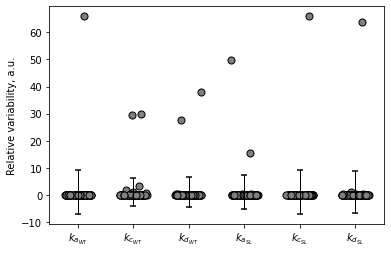

In [13]:
fig, ax = plt.subplots()

w = 0.5

for i in range(len(x)):
    mn = np.mean(param_scaled[i][~np.isnan(param_scaled[i])])
    std = np.std(param_scaled[i][~np.isnan(param_scaled[i])])
    ax.scatter(x[i] + np.random.random(param_scaled[i].size) * w - w/2,
               param_scaled[i],
               marker = 'o',
               edgecolor = 'black',
               linewidth = 1,
               s = 50,
               c = '#808080')
    ax.plot([x[i], x[i]],
            [mn - std, mn + std],
            linewidth = 1,
            color = 'black')
    ax.scatter(x[i],
               mn,
               marker = '_',
               s = 55,
               c = 'black')
    ax.scatter([x[i], x[i]],
               [mn - std, mn + std],
               marker = '_',
               s = 45,
               c = 'black')
    
    
ax.set_xticks(x, labels = xlabels)
ax.set_ylabel('Relative variability, a.u.')
#ax.set_yscale('log')

plt.savefig('relative_var_params.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [14]:
#filter outliers above 0.15
param_scaled_filtered = param_scaled
filtered = [0] * len(param_scaled_filtered)
for i in range(len(param_scaled_filtered)):
    for j in range(len(param_scaled_filtered[i])):
        if param_scaled_filtered[i][j] >= 0.15:
            param_scaled_filtered[i][j] = np.nan
            filtered[i] += 1

In [15]:
filtered

[1, 7, 4, 4, 1, 5]

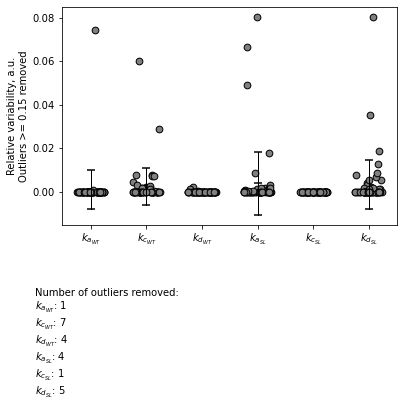

In [16]:
fig, ax = plt.subplots()

w = 0.5

for i in range(len(x)):
    mn = np.mean(param_scaled_filtered[i][~np.isnan(param_scaled_filtered[i])])
    std = np.std(param_scaled_filtered[i][~np.isnan(param_scaled_filtered[i])])
    ax.plot([x[i], x[i]],
            [mn - std, mn + std],
            linewidth = 1,
            color = 'black')
    ax.scatter(x[i],
               mn,
               marker = '_',
               s = 50,
               c = 'black')
    ax.scatter([x[i], x[i]],
               [mn - std, mn + std],
               marker = '_',
               s = 55,
               c = 'black')
    ax.scatter(x[i] + np.random.random(param_scaled_filtered[i].size) * w - w/2,
               param_scaled_filtered[i],
               marker = 'o',
               edgecolor = 'black',
               linewidth = 1,
               s = 45,
               c = '#808080')
    
ax.set_xticks(x, labels = xlabels)
ax.set_ylabel('Relative variability, a.u.\nOutliers >= 0.15 removed')

outliers_removed = 'Number of outliers removed:\n'
for i in range(len(filtered)):
    outliers_removed += f'{xlabels[i]}: {filtered[i]}\n'
ax.text(0, -.1, outliers_removed)

plt.savefig('relative_var_params_outliers-removed.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

##### Stats

In [15]:
import scipy.stats as st
import scikit_posthocs as sp

In [17]:
#scale each param by group mean again
##filtering messes up variable names...
param_scaled = []
for i in range(len(means)):
    param_scaled.append(param_vals[:, i] / means[i])

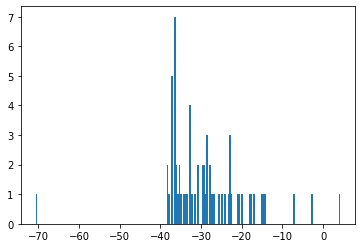

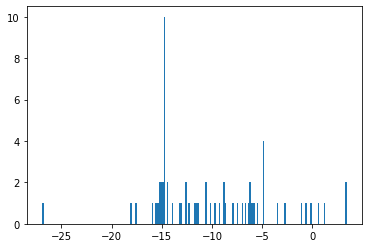

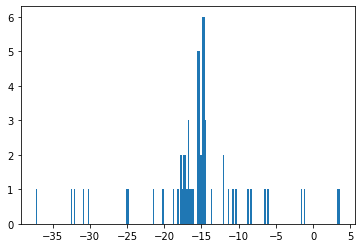

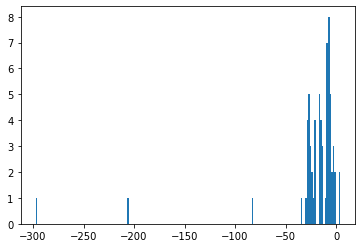

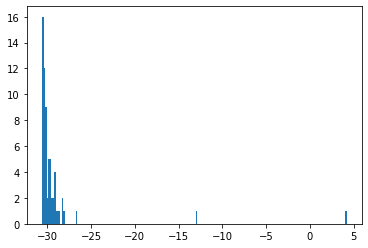

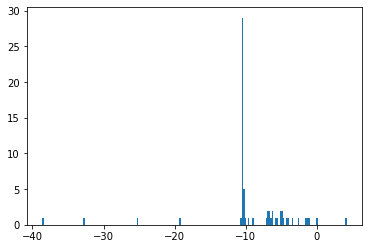

In [17]:
for i in range(len(param_scaled)):
    fig, ax = plt.subplots()
    
    ax.hist(np.log(param_scaled[i]), bins = 200)
    plt.show()

In [18]:
##Normality, equal variance assumed
stat, p = st.f_oneway(np.log(param_scaled[0][~np.isnan(param_scaled[0])]),
                     np.log(param_scaled[1][~np.isnan(param_scaled[1])]),
                     np.log(param_scaled[2][~np.isnan(param_scaled[2])]),
                     np.log(param_scaled[3][~np.isnan(param_scaled[3])]),
                     np.log(param_scaled[4][~np.isnan(param_scaled[4])]),
                     np.log(param_scaled[5][~np.isnan(param_scaled[5])]))
print(f'stat = {stat}, p = {p}')

stat = 14.752723146218475, p = 2.9180522471897727e-13


In [32]:
out = st.tukey_hsd(np.log(param_scaled[0][~np.isnan(param_scaled[0])]),
                     np.log(param_scaled[1][~np.isnan(param_scaled[1])]),
                     np.log(param_scaled[2][~np.isnan(param_scaled[2])]),
                     np.log(param_scaled[3][~np.isnan(param_scaled[3])]),
                     np.log(param_scaled[4][~np.isnan(param_scaled[4])]),
                     np.log(param_scaled[5][~np.isnan(param_scaled[5])]))


In [35]:
index = xlabels
columns = xlabels
df_pvals = pd.DataFrame(out.pvalue, index = index, columns = columns)
df_pvals

,$k_{a_{WT}}$,$k_{c_{WT}}$,$k_{d_{WT}}$,$k_{a_{SL}}$,$k_{c_{SL}}$,$k_{d_{SL}}$
$k_{a_{WT}}$,1.000000e+00,2.629922e-07,0.000697,0.347061,1.000000e+00,6.513446e-08
$k_{c_{WT}}$,2.629922e-07,1.000000e+00,0.566170,0.002684,2.557741e-07,9.998619e-01
$k_{d_{WT}}$,6.974814e-04,5.661701e-01,1.000000,0.284229,6.831437e-04,4.028599e-01
$k_{a_{SL}}$,3.470612e-01,2.683502e-03,0.284229,1.000000,3.441300e-01,1.016287e-03
$k_{c_{SL}}$,1.000000e+00,2.557741e-07,0.000683,0.344130,1.000000e+00,6.328553e-08
$k_{d_{SL}}$,6.513446e-08,9.998619e-01,0.402860,0.001016,6.328553e-08,1.000000e+00


In [36]:
df_stats = pd.DataFrame(out.statistic, index = index, columns = columns)
df_stats

,$k_{a_{WT}}$,$k_{c_{WT}}$,$k_{d_{WT}}$,$k_{a_{SL}}$,$k_{c_{SL}}$,$k_{d_{SL}}$
$k_{a_{WT}}$,0.000000,-18.936261,-13.508187,-6.564818,0.016806,-19.764918
$k_{c_{WT}}$,18.936261,0.000000,5.428075,12.371443,18.953067,-0.828656
$k_{d_{WT}}$,13.508187,-5.428075,0.000000,6.943368,13.524993,-6.256731
$k_{a_{SL}}$,6.564818,-12.371443,-6.943368,0.000000,6.581624,-13.200100
$k_{c_{SL}}$,-0.016806,-18.953067,-13.524993,-6.581624,0.000000,-19.781724
$k_{d_{SL}}$,19.764918,0.828656,6.256731,13.200100,19.781724,0.000000


In [29]:
#Normality testing
for i in range(len(param_scaled)):
    stat, p = st.shapiro(np.log(param_scaled[i][~np.isnan(param_scaled[i])]))
    
    print(f'{xlabels[i]}: stat = {stat}, p = {p}')

$k_{a_{WT}}$: stat = 0.8765766620635986, p = 8.872229955159128e-06
$k_{c_{WT}}$: stat = 0.9378821849822998, p = 0.0025277789682149887
$k_{d_{WT}}$: stat = 0.8629714250564575, p = 3.1188567390927346e-06
$k_{a_{SL}}$: stat = 0.38213634490966797, p = 3.560041360827198e-15
$k_{c_{SL}}$: stat = 0.27092236280441284, p = 1.959317041268143e-16
$k_{d_{SL}}$: stat = 0.7092501521110535, p = 3.90873611255671e-10


In [30]:
#Normality testing
for i in range(len(param_scaled)):
    stat, p = st.shapiro(param_scaled[i][~np.isnan(param_scaled[i])])
    
    print(f'{xlabels[i]}: stat = {stat}, p = {p}')

$k_{a_{WT}}$: stat = 0.10268789529800415, p = 4.309365318759346e-18
$k_{c_{WT}}$: stat = 0.19134914875030518, p = 2.991587028187445e-17
$k_{d_{WT}}$: stat = 0.1685882806777954, p = 1.792733652335151e-17
$k_{a_{SL}}$: stat = 0.14793741703033447, p = 1.1367398046292587e-17
$k_{c_{SL}}$: stat = 0.10250413417816162, p = 4.292762563094488e-18
$k_{d_{SL}}$: stat = 0.10711371898651123, p = 4.730424652376907e-18


In [37]:
##Not normal! Kruskal-Wallis
stat, p = st.kruskal(param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],
                     param_scaled[5][~np.isnan(param_scaled[5])])

print(f'stat = {stat}, p = {p}')

stat = 206.05378030360885, p = 1.4390879773035226e-42


In [38]:
#Dunn's post-hoc
df_dunn = sp.posthoc_dunn([param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],
                     param_scaled[5][~np.isnan(param_scaled[5])]], p_adjust = 'bonferroni')
df_dunn.columns = columns
df_dunn.index = index
df_dunn

,$k_{a_{WT}}$,$k_{c_{WT}}$,$k_{d_{WT}}$,$k_{a_{SL}}$,$k_{c_{SL}}$,$k_{d_{SL}}$
$k_{a_{WT}}$,1.000000e+00,1.603284e-19,1.378249e-07,3.824562e-11,1.000000e+00,1.848786e-23
$k_{c_{WT}}$,1.603284e-19,1.000000e+00,5.077146e-03,2.983272e-01,1.076571e-20,1.000000e+00
$k_{d_{WT}}$,1.378249e-07,5.077146e-03,1.000000e+00,1.000000e+00,2.502523e-08,1.014511e-04
$k_{a_{SL}}$,3.824562e-11,2.983272e-01,1.000000e+00,1.000000e+00,4.909360e-12,1.758502e-02
$k_{c_{SL}}$,1.000000e+00,1.076571e-20,2.502523e-08,4.909360e-12,1.000000e+00,9.607998e-25
$k_{d_{SL}}$,1.848786e-23,1.000000e+00,1.014511e-04,1.758502e-02,9.607998e-25,1.000000e+00


In [39]:
#re-run with filtered data
filtered = [0] * len(param_scaled)
for i in range(len(param_scaled)):
    for j in range(len(param_scaled[i])):
        if param_scaled[i][j] >= 0.15:
            param_scaled[i][j] = np.nan
            filtered[i] += 1
filtered

[1, 7, 4, 4, 1, 5]

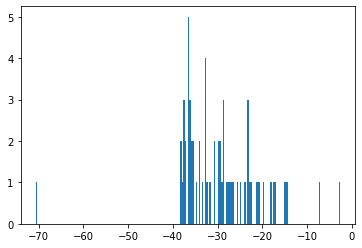

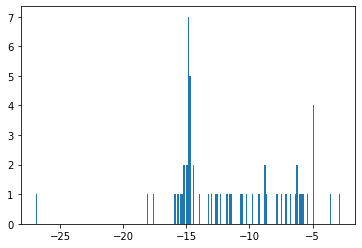

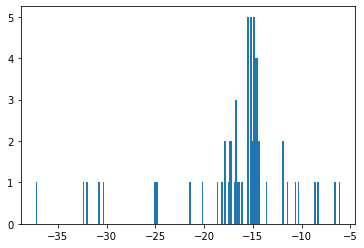

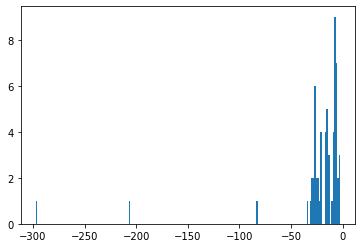

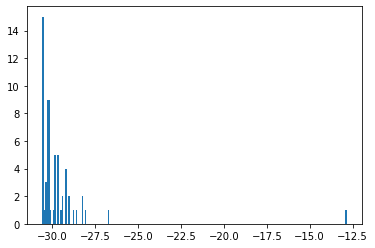

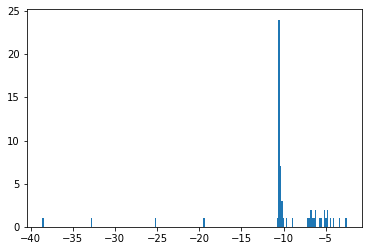

In [48]:
for i in range(len(param_scaled)):
    fig, ax = plt.subplots()
    
    ax.hist(np.log(param_scaled[i]), bins = 200)
    plt.show()

In [44]:
##Normality, equal variance assumed
stat, p = st.f_oneway(np.log(param_scaled[0][~np.isnan(param_scaled[0])]),
                     np.log(param_scaled[1][~np.isnan(param_scaled[1])]),
                     np.log(param_scaled[2][~np.isnan(param_scaled[2])]),
                     np.log(param_scaled[3][~np.isnan(param_scaled[3])]),
                     np.log(param_scaled[4][~np.isnan(param_scaled[4])]),
                     np.log(param_scaled[5][~np.isnan(param_scaled[5])]))
print(f'stat = {stat}, p = {p}')

stat = 13.32454834450237, p = 6.009986085548033e-12


In [50]:
out = st.tukey_hsd(np.log(param_scaled[0][~np.isnan(param_scaled[0])]),
                     np.log(param_scaled[1][~np.isnan(param_scaled[1])]),
                     np.log(param_scaled[2][~np.isnan(param_scaled[2])]),
                     np.log(param_scaled[3][~np.isnan(param_scaled[3])]),
                     np.log(param_scaled[4][~np.isnan(param_scaled[4])]),
                     np.log(param_scaled[5][~np.isnan(param_scaled[5])]))

In [51]:
index = xlabels
columns = xlabels
df_pvals = pd.DataFrame(out.pvalue, index = index, columns = columns)
df_pvals

,$k_{a_{WT}}$,$k_{c_{WT}}$,$k_{d_{WT}}$,$k_{a_{SL}}$,$k_{c_{SL}}$,$k_{d_{SL}}$
$k_{a_{WT}}$,1.000000e+00,0.000003,0.001921,0.564919,1.000000e+00,2.414545e-07
$k_{c_{WT}}$,2.638248e-06,1.000000,0.661229,0.004024,2.571721e-06,9.987067e-01
$k_{d_{WT}}$,1.920892e-03,0.661229,1.000000,0.252852,1.884016e-03,3.909641e-01
$k_{a_{SL}}$,5.649192e-01,0.004024,0.252852,1.000000,5.615403e-01,7.632781e-04
$k_{c_{SL}}$,1.000000e+00,0.000003,0.001884,0.561540,1.000000e+00,2.348992e-07
$k_{d_{SL}}$,2.414545e-07,0.998707,0.390964,0.000763,2.348992e-07,1.000000e+00


In [52]:
df_stats = pd.DataFrame(out.statistic, index = index, columns = columns)
df_stats

,$k_{a_{WT}}$,$k_{c_{WT}}$,$k_{d_{WT}}$,$k_{a_{SL}}$,$k_{c_{SL}}$,$k_{d_{SL}}$
$k_{a_{WT}}$,0.000000,-18.131876,-12.946712,-5.553136,0.017082,-19.508609
$k_{c_{WT}}$,18.131876,0.000000,5.185164,12.578740,18.148958,-1.376733
$k_{d_{WT}}$,12.946712,-5.185164,0.000000,7.393576,12.963794,-6.561897
$k_{a_{SL}}$,5.553136,-12.578740,-7.393576,0.000000,5.570218,-13.955473
$k_{c_{SL}}$,-0.017082,-18.148958,-12.963794,-5.570218,0.000000,-19.525691
$k_{d_{SL}}$,19.508609,1.376733,6.561897,13.955473,19.525691,0.000000


In [54]:
#Normality testing
for i in range(len(param_scaled)):
    stat, p = st.shapiro(np.log(param_scaled[i][~np.isnan(param_scaled[i])]))
    
    print(f'{xlabels[i]}: stat = {stat}, p = {p}')

$k_{a_{WT}}$: stat = 0.8810606598854065, p = 1.4514278518618084e-05
$k_{c_{WT}}$: stat = 0.918148398399353, p = 0.0007226773304864764
$k_{d_{WT}}$: stat = 0.8049787282943726, p = 1.2657513082103833e-07
$k_{a_{SL}}$: stat = 0.3708140254020691, p = 7.65717953724477e-15
$k_{c_{SL}}$: stat = 0.3403177261352539, p = 1.5030684352322285e-15
$k_{d_{SL}}$: stat = 0.6112908124923706, p = 1.9157023189997346e-11


In [55]:
##Not normal! Kruskal-Wallis
stat, p = st.kruskal(param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],
                     param_scaled[5][~np.isnan(param_scaled[5])])

print(f'stat = {stat}, p = {p}')

stat = 208.85188964831423, p = 3.623998884315573e-43


In [56]:
#Dunn's post-hoc
df_dunn = sp.posthoc_dunn([param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],
                     param_scaled[5][~np.isnan(param_scaled[5])]], p_adjust = 'bonferroni')
df_dunn.columns = columns
df_dunn.index = index
df_dunn

,$k_{a_{WT}}$,$k_{c_{WT}}$,$k_{d_{WT}}$,$k_{a_{SL}}$,$k_{c_{SL}}$,$k_{d_{SL}}$
$k_{a_{WT}}$,1.000000e+00,9.023919e-19,3.032954e-07,3.975230e-11,1.000000e+00,1.821684e-24
$k_{c_{WT}}$,9.023919e-19,1.000000e+00,5.463329e-03,4.035994e-01,5.675225e-20,1.000000e+00
$k_{d_{WT}}$,3.032954e-07,5.463329e-03,1.000000e+00,1.000000e+00,5.184242e-08,2.101298e-05
$k_{a_{SL}}$,3.975230e-11,4.035994e-01,1.000000e+00,1.000000e+00,4.535560e-12,8.057191e-03
$k_{c_{SL}}$,1.000000e+00,5.675225e-20,5.184242e-08,4.535560e-12,1.000000e+00,7.574393e-26
$k_{d_{SL}}$,1.821684e-24,1.000000e+00,2.101298e-05,8.057191e-03,7.574393e-26,1.000000e+00


## Plotting stdevs from all optimisations

In [96]:
#read in data
param_stdevs = []
param_vals = []
for i in tqdm(range(100)):
    dat_stdevs = pd.read_csv('outcmaes' + str(i) + '/stddev.dat', delimiter = '\\s', engine = 'python')
    param_stdevs.append(list(dat_stdevs.iloc[-1, 5:11]))    
    
    dat_vals = pd.read_csv('outcmaes' + str(i) + '/xrecentbest.dat', delimiter = '\\s', engine = 'python')
    param_vals.append(list(dat_vals.iloc[-1, 5:11]))

100%|██████████| 100/100 [00:03<00:00, 28.64it/s]


In [97]:
np.array(param_stdevs).shape == np.array(param_vals).shape

True

In [101]:
#transform params so all positive, scale stdevs
stdevs = np.exp(np.array(param_stdevs))
vals = np.exp(np.array(param_vals))

scaled_stds = stdevs / vals

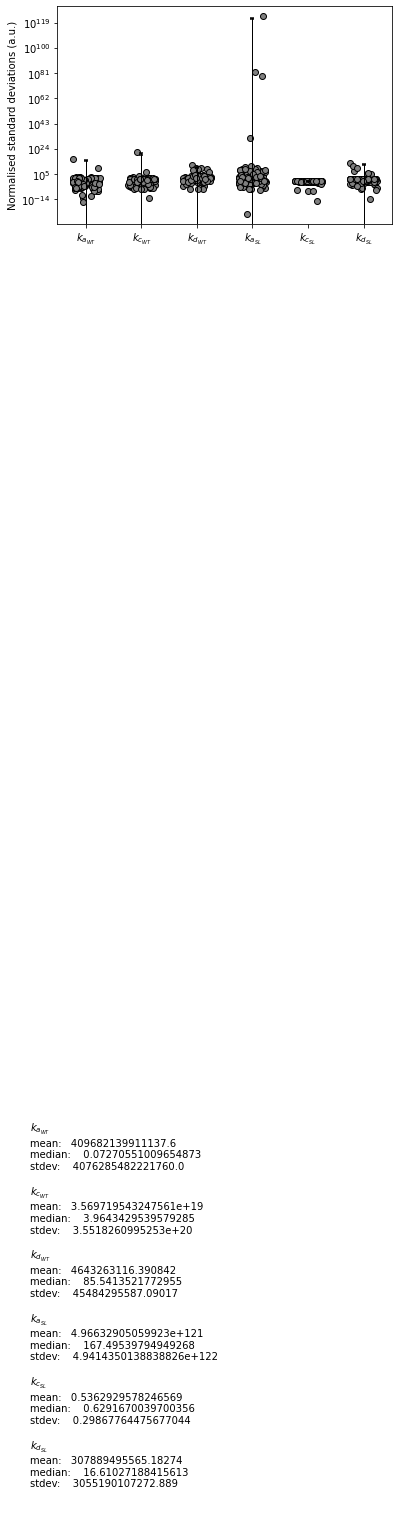

In [153]:
x = np.linspace(1, 6, 6)
xlabels = ['$k_{a_{WT}}$',  '$k_{c_{WT}}$',  '$k_{d_{WT}}$',  '$k_{a_{SL}}$',  '$k_{c_{SL}}$',  '$k_{d_{SL}}$']
w = 0.5

fig, ax = plt.subplots()

text_to_plot = ''

for i in range(scaled_stds.shape[1]):
    dat = scaled_stds.transpose()[i]#[~np.isnan(scaled_stds.transpose()[i])]
    ax.scatter(x[i] + np.random.random(dat.size) * w - w/2,
               dat,
               marker = 'o',
               linewidth = 1,
               edgecolor = 'black',
               c = '#808080')
    ax.plot([x[i], x[i]],
            [np.mean(dat) - np.std(dat), np.mean(dat) + np.std(dat)],
            linewidth = 1,
            color = 'black')
    ax.scatter(x[i],
               np.mean(dat),
               s = 12,
               color = 'black',
               marker = '_')
    ax.scatter([x[i], x[i]],
               [np.mean(dat) - np.std(dat), np.mean(dat) + np.std(dat)],
               marker = '_',
               s = 10,
               color = 'black')
    text_to_plot += xlabels[i] + '\nmean:   ' + str(np.mean(dat)) + '\nmedian:    ' + str(np.median(dat)) + '\nstdev:    ' + str(np.std(dat)) + '\n\n'
    
ax.set_xticks(x, xlabels)
ax.set_yscale('log')
ax.set_ylabel('Normalised standard deviations (a.u.)')
ax.text(0, 0, text_to_plot)

plt.show()

In [161]:
len(scaled_stds.transpose()) == len(x)

True

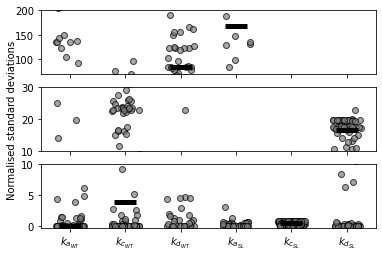

In [212]:
fig, ax = plt.subplots(3, sharex = True)

for j in range(3):
    for i in range(scaled_stds.shape[1]):
        dat = scaled_stds.transpose()[i]#[~np.isnan(scaled_stds.transpose()[i])]
        ax[j].scatter(x[i] + np.random.random(dat.size) * w - w/2,
                   dat,
                   marker = 'o',
                   linewidth = 1,
                   edgecolor = 'black',
                   c = '#808080',
                  alpha = 0.7)
        ax[j].scatter(x[i],
                   np.median(dat),
                   marker = '_',
                   s = 500,
                   c = 'black',
                    linewidth = 5)
    
ax[2].set_xticks(x, xlabels)
ax[1].set_ylabel('Normalised standard deviations')
ax[0].set_ylim(70, 200)
ax[1].set_ylim(10, 30)
ax[2].set_ylim(-.2, 10)


plt.show()

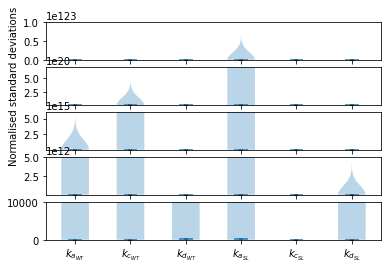

In [251]:
fig, ax = plt.subplots(5, sharex = True)

for j in range(5):
    for i in range(scaled_stds.shape[1]):
        dat = scaled_stds.transpose()[i]#[~np.isnan(scaled_stds.transpose()[i])]
        
        ax[j].scatter(x[i],
                   np.median(dat),
                   marker = '_',
                   s = 12,
                   c = 'black')
    ax[j].violinplot(scaled_stds,
              showextrema = False,
              showmedians = True,)
    
ax[4].set_xticks(x, xlabels)
ax[1].set_ylabel('Normalised standard deviations')
ax[0].set_ylim(1e110, 1e123)
ax[1].set_ylim(1e19, 1e21*.7)
ax[2].set_ylim(1e12, 1e15*6)
ax[3].set_ylim(1e5, 1e13*.5)
ax[4].set_ylim(0, 1e4)


plt.show()

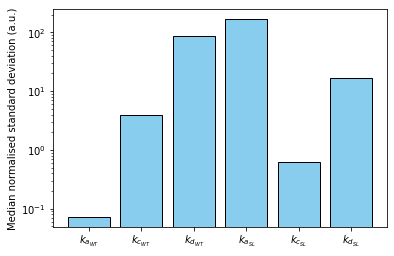

In [271]:
fig, ax = plt.subplots()

for i in range(scaled_stds.shape[1]):
    dat = scaled_stds.transpose()[i]#[~np.isnan(scaled_stds.transpose()[i])]
            
    ax.bar(x[i],
           height = np.median(dat),
          edgecolor = 'black',
             color = '#88CCEE')
    
ax.set_xticks(x, xlabels)
ax.set_ylabel('Median normalised standard deviation (a.u.)')
ax.set_yscale('log')

plt.savefig('optim-stdev-medians.svg', dpi = 600, bbox_inches = 'tight')

plt.show()